# Imitation learning

In this brief tutorial we show how to reproduce the Figures 6 and 7c of the Appendix of [our paper](soon). The goal is to show that projective simulation (PS) can imitate the policy of agent moving following a certain step length distribution. We focus on two distributions: Lévy and Bi-exponential.

First, let's load the needed libraries and functions. See that `rl_opts` needs to be already installed (see instructions in the README file).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from rl_opts.imitation import PS_imitation
from rl_opts.analytics import pdf_powerlaw, pdf_multimode, pdf_discrete_sample, get_policy

## Lévy distributions (Fig. 6a)
We consider distribution of the type $P(L)=L^{-1-\beta}$, with various $\beta$:

In [ ]:
NUM_STATES = 100 # size of the state space
EPOCHS = 100 # number of epochs
NUM_STEPS = 1000 # number of learning steps per episode


betas = [0.5, 1, 1.5, 2]
hmatrix_pw = np.zeros(tqdm(len(betas), NUM_STATES))

for idxb, beta in enumerate((betas)):
    
    # For every beta, we sample steps from the corresponding powerlaw (Levy dist.)    
    steps = pdf_discrete_sample(beta = beta,
                                pdf_func = pdf_powerlaw,                                
                                L_max = NUM_STATES,  
                                num_samples = (EPOCHS, NUM_STEPS))
    
    # We define the imitator and train it
    imitator = PS_imitation(num_states = NUM_STATES,
                            eta = int(1e-7),
                            gamma = 0)
    for e in (range(EPOCHS)):
        imitator.reset()
        for s in steps[e]:    
            imitator.update(length = s)
            
    # We only save the turn probability
    hmatrix_pw[idxb] = imitator.h_matrix[1]/imitator.h_matrix.sum(0)

Now `hmatrix_pw` contains the turn probability of an imitator agent for every $\beta$. We can now plot this and compare it with the theoretical prediction, calculated by means of the `get_policy` function.

<matplotlib.legend.Legend>

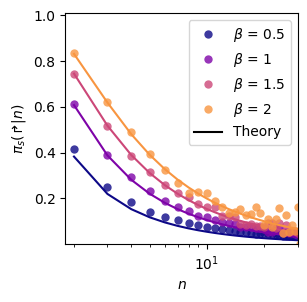

In [ ]:
fig, ax_pw = plt.subplots(figsize = (3,3))
color = plt.cm.plasma(np.linspace(0,1,len(betas)+1))

for idx, (h, beta) in enumerate(zip(hmatrix_pw, betas)):
    
    #---- Analytical solution ----#
    theory = get_policy(n_max = NUM_STATES, 
                        func = pdf_powerlaw,
                        beta = beta)
    ax_pw.plot(np.arange(2, NUM_STATES+1), 1-theory[1:], c = color[idx])
    
    #---- Numerical solution ----#
    ax_pw.plot(np.arange(2, NUM_STATES+2), h, 'o', 
               c = color[idx],  label = fr'$\beta$ = {beta}', alpha = 0.8, markeredgecolor='None', lw = 0.05)

#---- Plot features ----#
plt.setp(ax_pw, xlim = (1.8, 30), ylim = (0.0, 1.01),
         xlabel =r'$n$', ylabel = r'$\pi_s(\Rsh|n)$', 
         yticks = np.round(np.arange(0.2, 1.01, 0.2),1),
         yticklabels = np.round(np.arange(0.2, 1.01, 0.2),1).astype(str),
         xscale = 'log')
ax_pw.plot(10, 10, label = 'Theory', c = 'k')   
ax_pw.legend()

## Bi-exponentials (Fig. 6b)
We consider here distributions of the form
$$
\Pr(L) = \sum_{i=1,2} \omega_i (1-e^{-1/\lambda_i}) e^{-(L-1)/\lambda_i} \, ,
$$
with $\omega = [0.94, 0.06]$, $\lambda_2 = 5000$ and varying $\lambda_1$.

In [ ]:
NUM_STATES = 100 # size of the state space
EPOCHS = 100 # number of epochs
NUM_STEPS = 1000 # number of learning steps per episode

# Bi-exponential parameters (lambda_1 will vary)
omegas = np.array([0.94, 0.06])
lambdas = np.array([0, 5000]).astype(float)
lambdas_1 = [0.6, 0.6*2, 0.6*8, 0.6*16]

# Array saving the results
hmatrix_bi = np.zeros((len(lambdas_1), NUM_STATES))

for idx_l, lambda_1 in enumerate(tqdm(lambdas_1)):
    
    lambdas[0] = lambda_1
    steps = pdf_discrete_sample(pdf_func = pdf_multimode,
                                lambdas = lambdas,
                                probs = omegas,
                                L_max = NUM_STATES,  
                                num_samples = (EPOCHS, NUM_STEPS))

    imitator = PS_imitation(num_states = NUM_STATES,
                            eta = int(1e-7),
                            gamma = 0)


    for e in (range(EPOCHS)):
        imitator.reset()
        for s in steps[e]:    
            imitator.update(length = s)
    # We only save the turn probability
    hmatrix_bi[idx_l] = imitator.h_matrix[1]/imitator.h_matrix.sum(0)  

  0%|          | 0/4 [00:00<?, ?it/s]

<matplotlib.legend.Legend>

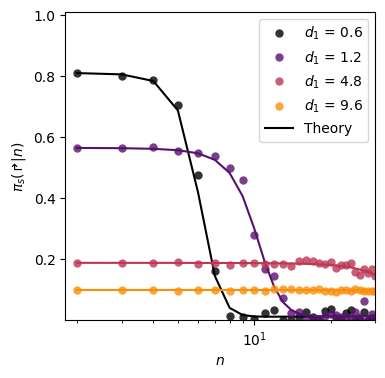

In [ ]:
fig, ax_bi = plt.subplots(figsize = (4,4))
color = plt.cm.inferno(np.linspace(0,1,len(lambdas_1)+1))

############# Powerlaw #################
for idx, (lambda_1, h) in enumerate(zip(lambdas_1, hmatrix_bi)):  
    
    #---- Analytical solution ----#
    lambdas[0] = lambda_1     
    theory = get_policy(n_max = NUM_STATES, 
                        func = pdf_multimode,
                        lambdas = lambdas,
                        probs = omegas,)
    ax_bi.plot(np.arange(2, NUM_STATES+1), 1-theory[1:], c = color[idx])
    
    #---- Numerical solution ----#
    ax_bi.plot(np.arange(2, NUM_STATES+2), h, 'o',               
               c = color[idx], 
               label = fr'$d_1$ = {np.round(lambda_1,1)}',
               alpha = 0.8, markeredgecolor='None')


#---- Plot features ----#
plt.setp(ax_bi, xlim = (1.8, 30), ylim = (0.0, 1.01),
         xlabel =r'$n$', ylabel = r'$\pi_s(\Rsh|n)$', 
         yticks = np.round(np.arange(0.2, 1.01, 0.2),1),
         yticklabels = np.round(np.arange(0.2, 1.01, 0.2),1).astype(str),
         xscale = 'log')
ax_bi.plot(10, 10, label = 'Theory', c = 'k')   
ax_bi.legend()
    

## Effect of a cutoff $L_{max}$ (Fig. 7c)
In our paper we explain that introducing a cutoff in the distribution used by the expert in the imitation scheme affects the resulting policy of the agent. Here we show this effect, using one of the previous bi-exponential policies as example:

In [ ]:
# Simulation parameters
NUM_STATES = 1000 # size of the state space
EPOCHS = 100 # number of epochs
NUM_STEPS = 1000 # number of learning steps per episode

# Distribution paremeters
omegas = np.array([0.94, 0.06])
lambdas = np.array([0.6, 5000])
# Get theoretical policy (without cutoff)
theory_nocutoff =  get_policy(n_max = NUM_STATES, 
                              func = pdf_multimode,
                              lambdas = lambdas,
                              probs = omegas,)


# Setting a max step length
L_cutoffs = [30, 150, 500, 2000, 10000]
# To make the loop more efficient, we sample now all steps,
# which we will then cut if the are bigger than L_cutoff
steps_og = pdf_discrete_sample(pdf_func = pdf_multimode,
                                lambdas = lambdas,
                                probs = omegas,
                                L_max = NUM_STATES,  
                                num_samples = EPOCHS*NUM_STEPS)


hmatrix_co = np.zeros((len(L_cutoffs), NUM_STATES))
for idx_c, L_cutoff in enumerate(tqdm(L_cutoffs)):

    # Copy steps we sampled above and apply cutoff. 
    # We re-generate the cutted steps
    steps = steps_og.copy()
    while np.max(steps) > L_cutoff:
        steps[steps > L_cutoff] = pdf_discrete_sample(pdf_func = pdf_multimode,
                                                      lambdas = lambdas,
                                                      probs = omegas,
                                                      L_max = NUM_STATES,
                                                      num_samples = len(steps[steps > L_cutoff]))
    steps = steps.reshape(EPOCHS, NUM_STEPS)
    
    # Define PS imitator
    imitator = PS_imitation(num_states = NUM_STATES,
                            eta = int(1e-7),
                            gamma = 0)
    # Training
    for e in (range(EPOCHS)):
        imitator.reset()
        for s in steps[e]:         
            imitator.update(length = s)
    # Saving
    hmatrix_co[idx_c] = imitator.h_matrix[1]/imitator.h_matrix.sum(0)


  0%|          | 0/5 [00:00<?, ?it/s]

[Text(0.5, 0, '$n$'), Text(0, 0.5, '$\\pi(\\Rsh|n)$'), None]

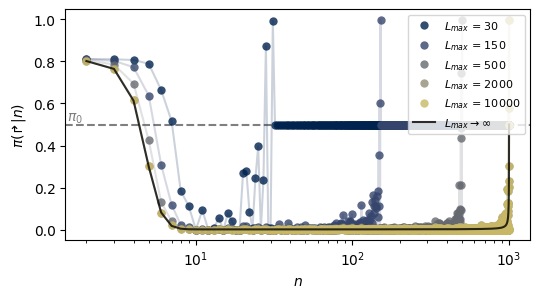

In [ ]:
fig, ax_co = plt.subplots(figsize = (6, 3))
color = plt.cm.cividis(np.linspace(0,1,len(L_cutoffs)+1))

for idx, (h, L_cutoff) in enumerate(zip(hmatrix_co, L_cutoffs)):  
    #---- Numerical solutions ----#
    ax_co.plot(np.arange(2, NUM_STATES+2), h, 'o',               
               c = color[idx],  label = r'$L_{max}$ = '+f'{L_cutoff}', 
               alpha = 0.8, markeredgecolor='None', rasterized=True)
    ax_co.plot(np.arange(2, NUM_STATES+2), h,                
               c = color[idx],  alpha = 0.2)

#---- Analytical solutions ----#
ax_co.plot(np.arange(2, NUM_STATES+1), 1-theory_nocutoff[1:], '-', 
           c = 'k', alpha = 0.8, label = r'$L_{max}\rightarrow \infty$') 

#---- Plot features ----#
ax_co.axhline(0.5, c = 'k', ls = '--', alpha = 0.5, zorder = -1)
ax_co.text(1.5, 0.52, r'$\pi_0$', alpha = 0.5)
plt.legend(loc = 'upper right', fontsize = 8)    
plt.setp(ax_co, xlabel =r'$n$', ylabel = r'$\pi(\Rsh|n)$', xscale = 'log')